# Locating Real Images

This notebook is for extracting real images from their FITS files.

First finds the coordinates for the field centers of each field, using this to find which field each point of interest is located in. This is then used to find and extract cutouts from the fields.

In [1]:
import pandas as pd
import numpy as np

# to get data from a FITS table
from astropy.io import fits
from astropy.table import Table

# to convert RA dec into actual form
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import FK5

The master catalog is based on the Revised Bologna Catalog and includes known GCs as well as objects that have been thought to be GCs. We need GCs (1), extended GCs (8) and the galaxies (4)

     1 = globular cluster;
     2 = candidate globular cluster;
     3 = controversial object;
     4 = galaxy;
     5 = HII region
     6 = star(s)
     7 = asterism;
     8 = extended cluster;
     

In [5]:
master_catalog_df = pd.read_csv('./data/csv/master_catalog_sept_2024.csv')
master_catalog_df

,ID,RADEG,DECDEG,CLASS,DATATABLE
0,C1,0.157917,32.417778,2,di_tullio_zinn_13_table2
1,2M034,0.508375,51.606722,4,m31rbcV5
2,PAndAS-03,0.985042,40.888667,1,huxor14_table1
3,PAndAS-04,1.178875,47.361797,1,huxor14_table1
4,PAndAS-05,1.350625,43.926583,1,huxor14_table1
...,...,...,...,...,...
2266,C74,356.707917,45.247222,2,di_tullio_zinn_13_table2
2267,C75,357.170417,39.629167,2,di_tullio_zinn_13_table2
2268,SDSS18,357.290417,40.458333,4,di_tullio_zinn_13_table1
2269,PAndAS-01,359.300125,43.552300,1,huxor14_table1


### Locating Field Centers

In [7]:
# load data of exposures from file in
# https://ws-sf.canfar.net/transfer/bmVpZ2g9U0ZVJnNpZ2V4cD0yMDIyMDcxMDE1MDc0NiZhcmM9Vk9TcGFjJmlkPTI0OTEwOTU0MCZ1c2VyPWFub25Vc2VyJm5zPVBBTkRBUyUyRlBVQkxJQyUyRkRPQ1MmbWV0aD1nZXQmYXV0aENvZGU9MCZydW5JRD1nOXNuZ2R2NnN1Z3E1ODNwJnVybD1odHRwJTNBJTJGJTJGc3Rvci1zZi0wMS5jYW5mYXIubmV0JTNBODg4OCUyRmFyY2hpdmUlMkY1ODA0MzQyYyUyRjE4ODklMkZ2b3NwYWMlMkZkZWZhdWx0JTJGMDAlMkYyNCUyRjcwJTJGMjQ5MTA5NTQwJTI1M0IlMjUzQjI3OTA0NDgzNw==-ZmlkPVRhYmxlMi50eHQmY2xuPTMwOTcyMiZjbWQ9MDQ4MWJjZWRlYWMwYjQ2ZTQxMDU3Y2I4YWUyMzg4OTQmbG1kPTE1Mzk3OTUxNzQ2NTM=-f7464048a902d90fb6fe371739d641b6/Table2.txt

pandas_obs_log = pd.read_csv('./data/csv/pandas_observing_log.txt',skiprows=35, header=None, delimiter=r"\s+")
col_names = ['obs_year','obs_month','obs_day','obs_hour','obs_min','obs_sec','mjd','RAh','RAm','RAs',\
         'DECd','DECm','DECs','ExpID','FieldID','OtherID','PID','Filter','Exp']
pandas_obs_log.columns = col_names
print(pandas_obs_log.head(2))

# concat coord columns into one string for astropy to use
pandas_obs_log['coord_string'] = pandas_obs_log['RAh'].astype(str)+' '+pandas_obs_log['RAm'].astype(str)+' '+ \
    pandas_obs_log['RAs'].astype(str)+' '+pandas_obs_log['DECd'].astype(str)+' '+pandas_obs_log['DECm'].astype(str)\
    +' '+pandas_obs_log['DECs'].astype(str)
                                                      
pandas_obs_log['coord_astropy'] = pandas_obs_log['coord_string'].apply(lambda x: SkyCoord(x, unit=(u.hourangle, u.deg)))
pandas_obs_log['coord_ra_deg'] = pandas_obs_log['coord_astropy'].apply(lambda x: x.ra.deg)
pandas_obs_log['coord_dec_deg'] = pandas_obs_log['coord_astropy'].apply(lambda x: x.dec.deg)

   obs_year  obs_month  obs_day  obs_hour  obs_min  obs_sec           mjd  \
0      2003          8       22        11       29    38.27  52873.478915   
1      2003          8       22        11       53    39.54  52873.495596   

   RAh  RAm   RAs  DECd  DECm  DECs   ExpID FieldID OtherID     PID    Filter  \
0    1   33  51.0    30    39  36.8  714745    m026    M33C  03BF15  g.MP9401   
1    1   33  51.0    30    39  36.8  714747    m026    M33C  03BF15  i.MP9701   

   Exp  
0  530  
1  660  


In [8]:
# group by field_id, the main way to identify a pointing,
# to then average the ra/dec form the various offset pointings
pandas_field_centres = pandas_obs_log.groupby('FieldID')[['coord_ra_deg','coord_dec_deg']].mean()

pandas_field_centres

,coord_ra_deg,coord_dec_deg
FieldID,,
m001,24.564181,27.638144
m002,23.464174,27.658144
m003,22.364174,27.938134
m004,24.564194,28.638148
m005,23.464194,28.658153
...,...,...
m402,8.127160,49.137894
m403,9.522208,49.736528
m404,5.188090,50.085593


In [ ]:
# save pandas field centres
pandas_field_centres.to_csv('./data/csv/pandas_field_centres.csv')

<Axes: xlabel='coord_ra_deg', ylabel='coord_dec_deg'>

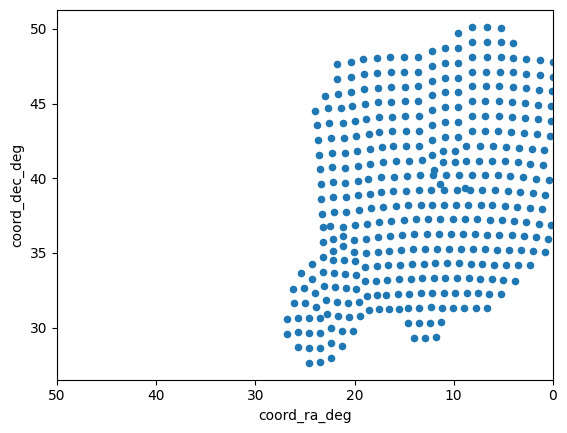

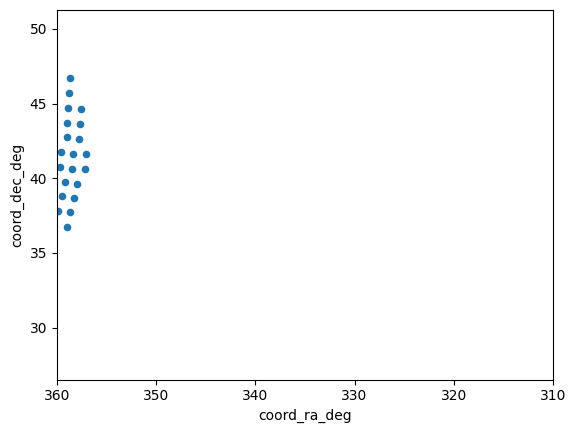

In [10]:
pandas_field_centres.plot.scatter(x='coord_ra_deg',y='coord_dec_deg',xlim=(50,0))
pandas_field_centres.plot.scatter(x='coord_ra_deg',y='coord_dec_deg',xlim=(360,310))

### Find Nearest Field for Specific Class of Objects

In [ ]:
# Using master catalog:
    # Filter for specific class (1 (GCs),8 extended GC),4 (galaxy))
    # Make sure to store rad and dec
filtered_catalog_df = master_catalog_df[master_catalog_df['CLASS'] == 4]
filtered_catalog_df.head()

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# Create SkyCoord objects for the master catalog and the pandas field centers
object_coords = SkyCoord(ra=filtered_catalog_df['RADEG'].values * u.deg,
                         dec=filtered_catalog_df['DECDEG'].values * u.deg,
                         frame='fk5')

In [ ]:
field_coords = SkyCoord(ra=pandas_field_centres['coord_ra_deg'].values * u.deg,
                        dec=pandas_field_centres['coord_dec_deg'].values * u.deg,
                        frame='fk5')

In [ ]:
# Use match_to_catalog_sky to find the closest field center for each object
idx, d2d, _ = object_coords.match_to_catalog_sky(field_coords)

In [ ]:
# Collect the results
object_id = filtered_catalog_df['ID'].values
raddeg = filtered_catalog_df['RADEG'].values
decdeg = filtered_catalog_df['DECDEG'].values
best_fit_pointing = pandas_field_centres.index.values[idx]  
min_dist = d2d.deg  # Minimum distances in degrees

In [ ]:
result_df = pd.DataFrame({
    'Object ID': object_id,
    'RADEG': raddeg,
    'DECDEG': decdeg,
    'Nearest field': best_fit_pointing,
    'Distance to nearest field': min_dist
})
result_df.to_csv('./data/csv/result_G.csv')

### Find Nearest Field for All Objects in CSV

In [3]:
import pandas as pd
import numpy as np

In [5]:
# Load the data
yilun_data = pd.read_csv('../data/csv/unique_rootness_coordinates_10deg.csv')
field_centres = pd.read_csv('../data/csv/pandas_field_centres.csv')

# Function to calculate the Haversine distance between two points
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of earth in kilometers is 6371
    km = 6371 * c
    return km

# Prepare the result dataframe
result = []

# Iterate over each row in the Yilun data
for index, yilun_row in yilun_data.iterrows():
    min_distance = float('inf')
    nearest_field = None
    
    # Iterate over each row in the field centres data
    for _, field_row in field_centres.iterrows():
        dist = haversine(yilun_row['RAJ2000'], yilun_row['DEJ2000'], field_row['coord_ra_deg'], field_row['coord_dec_deg'])
        if dist < min_distance:
            min_distance = dist
            nearest_field = field_row['FieldID']
    
    # Append the result
    result.append({
        'RADEG': yilun_row['RAJ2000'],
        'DECDEG': yilun_row['DEJ2000'],
        'Nearest field': nearest_field,
        'Distance to nearest field': min_distance
    })

# Convert the result list to a DataFrame
result_df = pd.DataFrame(result)

# Save the result to a new CSV file
result_df.to_csv('../data/csv/rootness_closest_fields_10deg.csv', index=False)

### Get Unique Fields for a CSV

Used to understand which FITS files will need to be downloaded and processed

In [6]:
import pandas as pd

In [7]:
# Load the CSV file
df = pd.read_csv('../data/csv/rootness_closest_fields_10deg.csv')

# Get unique values
unique_field_ids = df['Nearest field'].unique()

# Order the unique values
unique_field_ids.sort()

# Output
print(unique_field_ids)
print(len(unique_field_ids))

# Print unique field IDs in chunks of 25 (Used to make downloading easier)
chunk_size = 35
for i in range(0, len(unique_field_ids), chunk_size):
    chunk = unique_field_ids[i:i + chunk_size]
    print(f"Chunk {i // chunk_size + 1}: {chunk}")

['m054' 'm055' 'm062' 'm071' 'm073' 'm074' 'm078' 'm081' 'm090' 'm094'
 'm096' 'm097' 'm100' 'm111' 'm113' 'm114' 'm116' 'm117' 'm120' 'm130'
 'm134' 'm136' 'm150' 'm174' 'm176' 'm196' 'm236' 'm243' 'm260' 'm261'
 'm263' 'm280' 'm324' 'm330' 'm344' 'm350' 'm368' 'm370' 'm371' 'm383'
 'm386' 'm387' 'm388' 'm391' 'm392' 'm393' 'm395' 'm396' 'm397' 'm399'
 'm400' 'm402' 'm403' 'm405' 'm406']
55
Chunk 1: ['m054' 'm055' 'm062' 'm071' 'm073' 'm074' 'm078' 'm081' 'm090' 'm094'
 'm096' 'm097' 'm100' 'm111' 'm113' 'm114' 'm116' 'm117' 'm120' 'm130'
 'm134' 'm136' 'm150' 'm174' 'm176' 'm196' 'm236' 'm243' 'm260' 'm261'
 'm263' 'm280' 'm324' 'm330' 'm344']
Chunk 2: ['m350' 'm368' 'm370' 'm371' 'm383' 'm386' 'm387' 'm388' 'm391' 'm392'
 'm393' 'm395' 'm396' 'm397' 'm399' 'm400' 'm402' 'm403' 'm405' 'm406']


### Convert Folder of FITS files to CCDs

In [1]:
from astropy.io import fits
import os
import glob

# Define the input and output directories
input_dir = r'C:\Users\Squid\Downloads\Fits'
output_dir = '../data/ccd'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get a list of all FITS files in the input directory
fits_files = glob.glob(os.path.join(input_dir, '*.fit'))

# Loop over each FITS file
for fits_file in fits_files:
    print(f"Processing file: {fits_file}")
    try:
        # Open the FITS file
        hdul = fits.open(fits_file)

        # Get the base name of the input file without extension
        base_name = os.path.splitext(os.path.basename(fits_file))[0]

        # Loop through each HDU (Header/Data Unit) in the FITS file
        for i, hdu in enumerate(hdul):
            # Check if the HDU contains image data
            if isinstance(hdu, fits.ImageHDU) or isinstance(hdu, fits.PrimaryHDU) and i != 0:
                # Extract the data
                data = hdu.data
                # Save the data to a new FITS file
                output_filename = os.path.join(output_dir, f'{base_name}_ccd_{i}.fit')
                fits.writeto(output_filename, data, hdu.header, overwrite=True)
                print(f"Created: {output_filename}")

        # Close the FITS file
        hdul.close()

    except Exception as e:
        print(f"An error occurred while processing {fits_file}: {e}\n")

Processing file: C:\Users\Squid\Downloads\Fits\m350_g.fit
Created: ../data/ccd\m350_g_ccd_1.fit
Created: ../data/ccd\m350_g_ccd_2.fit
Created: ../data/ccd\m350_g_ccd_3.fit
Created: ../data/ccd\m350_g_ccd_4.fit
Created: ../data/ccd\m350_g_ccd_5.fit
Created: ../data/ccd\m350_g_ccd_6.fit
Created: ../data/ccd\m350_g_ccd_7.fit
Created: ../data/ccd\m350_g_ccd_8.fit
Created: ../data/ccd\m350_g_ccd_9.fit
Created: ../data/ccd\m350_g_ccd_10.fit
Created: ../data/ccd\m350_g_ccd_11.fit
Created: ../data/ccd\m350_g_ccd_12.fit
Created: ../data/ccd\m350_g_ccd_13.fit
Created: ../data/ccd\m350_g_ccd_14.fit
Created: ../data/ccd\m350_g_ccd_15.fit
Created: ../data/ccd\m350_g_ccd_16.fit
Created: ../data/ccd\m350_g_ccd_17.fit
Created: ../data/ccd\m350_g_ccd_18.fit
Created: ../data/ccd\m350_g_ccd_19.fit
Created: ../data/ccd\m350_g_ccd_20.fit
Created: ../data/ccd\m350_g_ccd_21.fit
Created: ../data/ccd\m350_g_ccd_22.fit
Created: ../data/ccd\m350_g_ccd_23.fit
Created: ../data/ccd\m350_g_ccd_24.fit
Created: ../dat

### Extract Images from CCD

In [2]:
IMAGE_SIZE = 128

In [3]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
import astropy.units as u
import numpy as np
from astropy.visualization import ZScaleInterval
from PIL import Image
import glob
import os
import pandas as pd

# Define the input and output directories and corresponding CSV files
configurations = [
    {'csv_file': '../data/csv/rootness_closest_fields_10deg.csv', 'output_dir': '../data/cutouts'}
    # {'csv_file': 'result_GC.csv', 'output_dir': './data/cluster_cutouts'},
    # {'csv_file': 'result_EGC.csv', 'output_dir': './data/extended_cluster_cutouts'}
]
input_dir = '../data/ccd'

# Function to check if pixel is within image bounds
def is_within_image(x, y, nx, ny):
    return (0 <= x < nx) and (0 <= y < ny)

# Function to convert FITS data to PNG with resampling
def fits_to_png(data, output_png, image_size=IMAGE_SIZE):
    # Replace NaNs or Infs with zeros to avoid issues
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

    # Apply Zscale normalization to raw data
    zscale = ZScaleInterval()
    vmin, vmax = zscale.get_limits(data)

    # Clip the data to the Zscale range
    clipped_data = np.clip(data, vmin, vmax)

    # Apply asinh scaling on the clipped data
    scaled_data = np.arcsinh(clipped_data)

    # Recompute the min/max for the asinh-transformed data
    scaled_vmin = scaled_data.min()
    scaled_vmax = scaled_data.max()

    # Normalise the scaled data to the range [0, 255] for 8-bit image representation
    scaled_data = (scaled_data - scaled_vmin) / (scaled_vmax - scaled_vmin)
    scaled_data = (scaled_data * 255).astype(np.uint8)

    # Create an image using PIL
    img = Image.fromarray(scaled_data)

    # Resize the image if a specific size is provided
    if image_size is not None:
        img = img.resize((image_size, image_size), Image.LANCZOS)

    # Save the image as PNG
    img.save(output_png)

# Process each configuration
for config in configurations:
    csv_file = config['csv_file']
    output_dir = config['output_dir']
    os.makedirs(output_dir, exist_ok=True)

    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Get a list of all FITS files in the input directory
    fits_files = glob.glob(os.path.join(input_dir, '*.fit'))
    fits_basenames = {os.path.basename(f).split('_')[0] for f in fits_files}

    # Filter the DataFrame to only include rows with corresponding FITS files
    df = df[df['Nearest field'].isin(fits_basenames)]
    ra_list = df['RADEG'].values
    dec_list = df['DECDEG'].values

    # Loop over each FITS file
    for fits_file in fits_files:
        # print(f"Processing file: {fits_file}")
        try:
            # Load the FITS file and extract WCS
            with fits.open(fits_file) as hdulist:
                # Adjust the index if your image is not in the primary HDU
                header = hdulist[0].header
                data = hdulist[0].data

                # Extract WCS information
                wcs = WCS(header)

                # Image dimensions
                naxis1 = header['NAXIS1']  # Width
                naxis2 = header['NAXIS2']  # Height

                # Loop over each coordinate in the filtered DataFrame
                for ra, dec in zip(ra_list, dec_list):
                    sky_coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

                    # Convert sky coordinate to pixel coordinate
                    x_pixel, y_pixel = wcs.world_to_pixel(sky_coord)

                    # Check if pixel coordinates are within image bounds
                    if is_within_image(x_pixel, y_pixel, naxis1, naxis2):
                        print(f"The sky coordinate ({ra}, {dec}) is within the image.")

                        # Define the size of the cutout (e.g., 100x100 pixels)
                        cutout_size = (IMAGE_SIZE, IMAGE_SIZE)  # (ny, nx)

                        # Create the cutout
                        cutout = Cutout2D(data, (x_pixel, y_pixel), cutout_size, wcs=wcs)

                        # Save the cutout as a PNG file
                        png_filename = os.path.join(output_dir, f'cutout_{os.path.basename(fits_file).replace(".fit", f"_{ra}_{dec}.png")}')
                        fits_to_png(cutout.data, png_filename)
                        print(f"Cutout saved to: {png_filename}")

        except Exception as e:
            print(f"An error occurred while processing {fits_file}: {e}")

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (1.83716358, 45.85676696) is within the image.
Cutout saved to: ../data/cutouts\cutout_m350_g_ccd_20_1.83716358_45.85676696.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (2.46994177, 46.63299444) is within the image.
Cutout saved to: ../data/cutouts\cutout_m370_g_ccd_33_2.46994177_46.63299444.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (17.7462473, 47.52048119) is within the image.
Cutout saved to: ../data/cutouts\cutout_m371_g_ccd_5_17.7462473_47.52048119.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (19.77135337, 47.42866635) is within the image.
Cutout saved to: ../data/cutouts\cutout_m383_g_ccd_36_19.77135337_47.42866635.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (18.73233825, 48.26497287) is within the image.
Cutout saved to: ../data/cutouts\cutout_m386_g_ccd_7_18.73233825_48.26497287.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (2.32098579, 47.93916235) is within the image.
Cutout saved to: ../data/cutouts\cutout_m387_g_ccd_25_2.32098579_47.93916235.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (14.98674796, 47.78622718) is within the image.
Cutout saved to: ../data/cutouts\cutout_m392_g_ccd_32_14.98674796_47.78622718.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.09251544, 48.52419726) is within the image.
Cutout saved to: ../data/cutouts\cutout_m395_g_ccd_5_8.09251544_48.52419726.png
The sky coordinate (7.90178957, 48.50763622) is within the image.
Cutout saved to: ../data/cutouts\cutout_m395_g_ccd_6_7.90178957_48.50763622.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (3.85513755, 49.23236572) is within the image.
Cutout saved to: ../data/cutouts\cutout_m399_g_ccd_15_3.85513755_49.23236572.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (4.24771904, 48.73863879) is within the image.
Cutout saved to: ../data/cutouts\cutout_m399_g_ccd_31_4.24771904_48.73863879.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (5.71054606, 48.88887162) is within the image.
Cutout saved to: ../data/cutouts\cutout_m400_g_ccd_20_5.71054606_48.88887162.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.4304233, 48.64591519) is within the image.
Cutout saved to: ../data/cutouts\cutout_m402_g_ccd_30_8.4304233_48.64591519.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


The sky coordinate (8.15695347, 50.00815794) is within the image.
Cutout saved to: ../data/cutouts\cutout_m406_g_ccd_23_8.15695347_50.00815794.png


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


### Modify Image Resolution

In [ ]:
import os
from PIL import Image

def resize_images(input_folder, output_folder, new_resolution):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(input_folder, filename)
            img = Image.open(img_path)
            img = img.resize((new_resolution, new_resolution), Image.ANTIALIAS)
            img.save(os.path.join(output_folder, filename))

input_folder = './data/cutouts/cluster_cutouts'
output_folder = './data/cutouts/downsample/cluster_cutouts'
new_resolution = 64

resize_images(input_folder, output_folder, new_resolution)

### Locate Duplicate Image

Checks for any images which have the same co-ordinates as eachother. This happens when an image is located at the edge of the CCD, meaning there is some overlap with an adjacent ccd

In [ ]:
import os
import shutil
import glob

In [ ]:
# Define the directory containing the files
directory = './data/finalised_cutouts/extended_cluster_cutouts'

# Get a list of all files in the directory
files = glob.glob(os.path.join(directory, '*.png'))

# Dictionary to store filenames by coordinates
coord_dict = {}

# First pass: Identify all coordinates that have duplicates
for file in files:
    # Extract the base name of the file
    base_name = os.path.basename(file)
    
    # Extract the coordinates from the filename
    parts = base_name.split('_')
    coords = f"{parts[-2]}_{parts[-1].replace('.png', '')}"
    
    # Add the file to the dictionary
    if coords in coord_dict:
        coord_dict[coords].append(file)
    else:
        coord_dict[coords] = [file]

# Second pass: Rename files with duplicate coordinates
for coords, file_list in coord_dict.items():
    if len(file_list) > 1:
        for file in file_list:
            base_name = os.path.basename(file)
            parts = base_name.split('_')
            new_name = f"{'_'.join(parts[:-2])}_{coords}_partial.png"
            new_path = os.path.join(directory, new_name)
            os.rename(file, new_path)
            print(f"Renamed {file} to {new_path}")

Moves any images marked as partial to a different folder

In [ ]:
def move_files_with_word(src_folder, dest_folder, word):
    # Create the destination folder if it doesn't exist
    os.makedirs(dest_folder, exist_ok=True)

    # Loop through all files in the source folder
    for filename in os.listdir(src_folder):
        # Check if the word is in the filename
        if word in filename:
            # Construct full file path
            src_file = os.path.join(src_folder, filename)
            dest_file = os.path.join(dest_folder, filename)
            # Move the file
            shutil.move(src_file, dest_file)
            print(f"Moved: {src_file} to {dest_file}")

# Source and destination folders
src_folder = './data/finalised_cutouts/galaxy_cutouts'
dest_folder = './data/finalised_cutouts/partials/galaxy'
word = 'partial'

move_files_with_word(src_folder, dest_folder, word)

### Cross Referencing Catalogues

Cross references a CSV of coords with a folder of images, checking if any are known cluster/non-cluster

In [ ]:
import os
import pandas as pd

In [ ]:
# Load the CSV files
csv_files = {
    './data/csv/result_G.csv': 'galaxy',
    './data/csv/result_GC.csv': 'cluster',
    './data/csv/result_EGC.csv': 'extended_cluster'
}

# Directory containing the images
image_directory = './data/predictions/non-cluster'  # Replace with your image directory

# Iterate over each CSV file
for csv_file, label in csv_files.items():
    df = pd.read_csv(csv_file)
    
    # Iterate over each file in the image directory
    for filename in os.listdir(image_directory):
        file_path = os.path.join(image_directory, filename)
        
        # Check if the file is an image
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            # Extract RA and DEC from the filename
            ra_dec_in_filename = False
            for index, row in df.iterrows():
                ra = str(row['RADEG'])
                dec = str(row['DECDEG'])
                if ra in filename and dec in filename:
                    ra_dec_in_filename = True
                    break
            
            # Determine the new filename
            if ra_dec_in_filename:
                new_filename = filename.replace('.png', f'_{label}_known.png').replace('.jpg', f'_{label}_known.jpg').replace('.jpeg', f'_{label}_known.jpeg').replace('.bmp', f'_{label}_known.bmp')
                new_file_path = os.path.join(image_directory, new_filename)
                os.rename(file_path, new_file_path)
                print(f"Renamed {file_path} to {new_file_path}")

Cross reference two catalogues to check for any duplicates

In [ ]:
# Load the CSV files
master_catalog_file = 'master_catalog_sept_2024.csv'
result_comparison_file = 'result_comparison.csv'
output_file = 'cross_referenced_results.csv'

# Read the CSV files into DataFrames
master_catalog_df = pd.read_csv(master_catalog_file)
result_comparison_df = pd.read_csv(result_comparison_file)

# Filter the master catalog to only include classes 1, 4, and 8
filtered_master_catalog_df = master_catalog_df[master_catalog_df['CLASS'].isin([1, 4, 8])]

# Create rounded columns for comparison
filtered_master_catalog_df['RADEG_ROUNDED'] = filtered_master_catalog_df['RADEG'].round(3)
filtered_master_catalog_df['DECDEG_ROUNDED'] = filtered_master_catalog_df['DECDEG'].round(3)
result_comparison_df['RADEG_ROUNDED'] = result_comparison_df['RADEG'].round(3)
result_comparison_df['DECDEG_ROUNDED'] = result_comparison_df['DECDEG'].round(3)

# Merge the DataFrames on the rounded RADEG and DECDEG columns
merged_df = pd.merge(filtered_master_catalog_df, result_comparison_df, on=['RADEG_ROUNDED', 'DECDEG_ROUNDED'])

# Drop the rounded columns from the merged DataFrame
merged_df.drop(columns=['RADEG_ROUNDED', 'DECDEG_ROUNDED'], inplace=True)

# Write the merged DataFrame to a new CSV file
merged_df.to_csv(output_file, index=False)

# Print the number of objects in each class in the resulting DataFrame
class_counts = merged_df['CLASS'].value_counts()
print("Number of objects in each class in the resulting DataFrame:")
print(class_counts)

print(f"Cross-referenced results saved to {output_file}")

Count how many of the cross referenced clusters exist in each class of predictions

In [ ]:
# Load the CSV files
cross_referenced_file = 'cross_referenced_results.csv'
cross_referenced_df = pd.read_csv(cross_referenced_file)

# Filter the cross-referenced DataFrame to only include class 1 objects
class_1_df = cross_referenced_df[cross_referenced_df['CLASS'] == 1]

# Create a set of RADEG and DECDEG tuples for class 1 objects
class_1_coords = set(zip(class_1_df['RADEG_y'], class_1_df['DECDEG_y']))

# Directories to check
cluster_dir = './data/predictions_128SRNC/cluster'
non_cluster_dir = './data/predictions_128SRNC/non-cluster'

# Function to count matching images in a directory
def count_matching_images(directory, coords_set):
    count = 0
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            for ra, dec in coords_set:
                if f"{ra}" in filename and f"{dec}" in filename:
                    count += 1
                    break
    return count

# Count matching images in cluster and non-cluster directories
cluster_count = count_matching_images(cluster_dir, class_1_coords)
non_cluster_count = count_matching_images(non_cluster_dir, class_1_coords)

# Output the results
print(f"Number of class 1 objects in cluster: {cluster_count}")
print(f"Number of class 1 objects in non-cluster: {non_cluster_count}")